# S591 NFDRS Version 4.0 Live Fuel Moisture model exploration<br>
Series 1, 12 Jan 2023<br>
<hr>


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import *
import warnings
from scipy.stats import spearmanr
from scipy import stats
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

### Basic plotting variables to standardize plots

In [6]:
# time series lines
clrs_lst=['#a6611a','#dfc27d','#80cdc1','#018571']
clr_ts1=clrs_lst[0]
clr_ts2=clrs_lst[1]
clr_ts3=clrs_lst[2]
clr_ts4=clrs_lst[3]

# scatter markers
mkrs_lst=['s','o','v']
mkr_ts2=mkrs_lst[0]
mkr_ts3=mkrs_lst[1]
mkr_ts4=mkrs_lst[2]

# marker size for all
mkr_sze=25

# qualitative color palette in NF alphabetical order
clrs_lst=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
clr_nf1=clrs_lst[0]
clr_nf2=clrs_lst[1]
clr_nf3=clrs_lst[2]
clr_nf4=clrs_lst[3]
clr_nf5=clrs_lst[4]
clr_nf6=clrs_lst[5]

# edge color for all
clr_edg_nf='black'

# edge linewidth for all
edg_lw_nf=0.5

# marker symbols in NF alphabetical order
mkrs_list=['o','X','s','P','D','*']
mkr_nf1=mkrs_list[0]
mkr_nf2=mkrs_list[1]
mkr_nf3=mkrs_list[2]
mkr_nf4=mkrs_list[3]
mkr_nf5=mkrs_list[4]
mkr_nf6=mkrs_list[5]

# alpha for all
clr_alpha=1

In [7]:
# Source: https://colorbrewer2.org/#type=diverging&scheme=Spectral&n=5
col1 = '#d7191c'
col2 = '#fdae61'
col3 = '#ffffbf'
col4 = '#abdda4'
col5 = '#2b83ba'

Note about colors:  Many standard color palettes are hard for many people to see. I like this website that has good, colorblind friendly palettes.  You can steal these colors and use directly anywhere in Python: https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=11

In [8]:
cmap = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']

### Basic met functions, photoperiod and conversions

In [9]:
## \fn satvap (self,Temp)
## \brief Calculate the Saturation Vapor Pressure from the temperature passed
## \param Temp Temperature (deg C)
def satvap (Temp):
    kTemp = Temp  + 273.16
    return exp(1.81 + (kTemp * 17.27 - 4717.31) / (kTemp - 35.86))

## \fn fToC Converts Fahrenheit to Celcius
## \param f Temperature in deg F
## \return c Temperature in deg C
def fToc(f):
    return (f -32) * 5/9

## \fn cTof Converts Celcius to Fahrenheit
## \param c Temperature in deg C
## \return f Temperature in deg F
def cTof(c):
    return (c * 9/5) + 32
INC = 0	#GSI Function Types, Increasing (Tmin, Dayl)
DEC = 1 #GSI Function Types, Decreasing (VPD)
MM_2_IN = 0.0393701  # Conversion factor from mm to inches
KPH_2_MPH = 0.621371 # Conversion factor from KPH to MPH

## \brief Calculate Daylight hours as a function of Latitude and Julian Date
## \param Julian Julian Year Day (1-366)

def CalcDaylightHours(Lat,Julian):
    phi = 0.0
    xfact = 0.0
    decl = 0.0
    tla = 0.0
    phi = tan(Lat * 0.01745) * -1.0
    xfact = (Julian - 80) * 0.01745
    decl = 23.5 * sin(xfact)
    decl = decl * 0.01745
    tla = phi * sin(decl)

    if (fabs(tla) < .01):
        tla = 0.01
    else:
        if (tla >= 1.0):
            tla = 0.99999999
        else:
            if (tla <= -1.0):
                tla = -.9999999


    tla = atan(sqrt((1.0 - tla * tla))/tla)
    if (tla < 0.0):
        tla = tla + 3.141593
    return tla * 7.64


def CalcDayl(lat,yday):
    RADPERDAY = 0.017214
    RADPERDEG = 0.01745329
    MINDECL = -0.4092797
    SECPERRAD = 13750.9871
    DAYSOFF = 10.25
    # Daylength function from MT-CLIM */
    lat = lat * RADPERDEG
    if lat > 1.5707:
        lat = 1.5707
    if lat < -1.5707:
        lat = -1.5707
    coslat = cos(lat)
    sinlat = sin(lat)

    #* calculate cos and sin of declination */
    decl = MINDECL * cos((yday + DAYSOFF) * RADPERDAY)
    cosdecl = cos(decl)
    sindecl = sin(decl)
    cosegeom = coslat * cosdecl
    sinegeom = sinlat * sindecl
    coshss = -(sinegeom) / cosegeom
    if coshss < -1.0:
        coshss = -1.0  # 24-hr daylight */
    if coshss > 1.0:
        coshss = 1.0    # 0-hr daylight */
    hss = acos(coshss)                # hour angle at sunset (radians) */
    #* daylength (seconds) */
    return 2.0 * hss * SECPERRAD

# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
def CalcVP(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Calculate the VPD from RH and temperature
def CalcVPD(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd

### Old GSI Indicator Functions, replaced below
def GetTminInd(Tmin,m_TminMin=-2,m_TminMax=5):
    if(m_TminMax == m_TminMin):
        return 0
    if( Tmin < m_TminMin):
        return 0
    elif(Tmin > m_TminMax):
        return 1
    else:
        return (Tmin - m_TminMin) / (m_TminMax - m_TminMin)

def GetVPDInd(VPD,m_VPDMin=900,m_VPDMax=4100):
    if(m_VPDMax == m_VPDMin):
        return 0
    if( VPD < m_VPDMin):
        return 1
    elif(VPD > m_VPDMax):
        return 0
    else:
        return 1 - (VPD - m_VPDMin) / (m_VPDMax - m_VPDMin)

def GetDaylInd(Dayl,m_DaylenMin=36000,m_DaylenMax=39600):
    if(m_DaylenMin == m_DaylenMax):
        return 0
    if( Dayl < m_DaylenMin):
        return 0
    elif(Dayl > m_DaylenMax):
        return 1
    else:
        return (Dayl - m_DaylenMin) / (m_DaylenMax - m_DaylenMin)

In [10]:
VERBOSE = False  # A flag to turn on and off diagnostics and summaries

## Read the data for Malibu RAWS in FW21 format

In [25]:
Lat = 34.06   # Station Latitude in decimal degrees
Lat045433 = Lat
fwx = pd.read_csv("./Data/045433.fw21")
Site = "Malibu RAWS (045433)"
YearRange = "2015-2019"
fwx.rename(columns=lambda x: x.strip(), inplace=True)  # This makes sure there are no random spaces in column names
fwx['DateTime']=pd.to_datetime(fwx['DateTime'])
fwx['JDay'] = fwx.DateTime.dt.dayofyear  # Store the day of the year for Daylength calculations
if VERBOSE:
    fwx.head()
#fwx

In [ ]:
# You can use this line to limit the data including the data frame.  
# This line will make sure we don't include any data from 2022.
fwx = fwx[(fwx['DateTime'] <= '2020-12-31')]

In [ ]:
# Calculate hourly VPD for each record in the dataframe
fwx['VPD(Pa)'] = fwx.apply(lambda row: CalcVPD(row['RelativeHumidity(%)'],row['Temperature(F)']),axis=1)

In [ ]:
# Use of resample requires us to set the DateTime as the Index
# This is a great reference for resample: 
# https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4
fwx_hourly = fwx.set_index('DateTime')
Tmin = pd.DataFrame({"Tmin": fwx_hourly['Temperature(F)'].resample('D').min()})  
Tmax = pd.DataFrame({"Tmax": fwx_hourly['Temperature(F)'].resample('D').max()})
Tavg = pd.DataFrame({"Tavg": fwx_hourly['Temperature(F)'].resample('D').mean()})
#VPDMax = pd.DataFrame({"VPDMax": fwx_hourly['VPD(Pa)'].resample('D').max()})
#VPDAvg = pd.DataFrame({"VPDAvg": fwx_hourly['VPD(Pa)'].resample('D').mean()})
Prcp = pd.DataFrame({"Prcp": fwx_hourly['Precipitation(in)'].resample('D').sum()})
RHmin = pd.DataFrame({"RHmin": fwx_hourly['RelativeHumidity(%)'].resample('D').min()})
RHmax = pd.DataFrame({"RHmax": fwx_hourly['RelativeHumidity(%)'].resample('D').max()})
RHavg = pd.DataFrame({"RHavg": fwx_hourly['RelativeHumidity(%)'].resample('D').mean()})

In [ ]:
## Calculate Daylength / Photoperiod for the DataFrame
### Note: This only requires latitude and day of year 

In [ ]:
# Create daily DataFrame
fwx_daily = pd.concat([Tmax,Tmin,RHmax,RHmin,Prcp],axis=1)
fwx_daily['DateTime'] = fwx_daily.index
fwx_daily = fwx_daily.dropna()
fwx_daily['JDay'] = fwx_daily.DateTime.dt.dayofyear
fwx_daily['Dayl'] = fwx_daily.apply(lambda row: CalcDayl(Lat,row['JDay']),axis=1)
fwx_daily = fwx_daily[fwx_daily['Prcp'] < 10]  # Just filtering out some crazy values here. Only ~2 days...

In [ ]:
fwx_daily['VPDMax'] = fwx_daily.apply(lambda row: CalcVPD(row['RHmin'],row['Tmax']),axis=1)

In [ ]:
# Make a simple plot of Daylength. It doesn't change from year to year.
ax = fwx_daily['Dayl'].groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color=col1)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Daylength (Seconds)")
plt.grid()

In [ ]:
f,ax = plt.subplots()
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(ax=ax,color=col5)
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(ax=ax,color=col1)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
ax.set_title(f"{Site} {YearRange}")
plt.grid()

In [ ]:
# Convert temperature from F to C
# fwx_daily['TminC'] =  (fwx_daily.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius

In [16]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

In [ ]:
# Test the indicator function over a range of temperature
t = [-3,-2,-1,0,1,2,3,4,5,6,7]
ind = []
for v in t:
    ind.append(Ind(v,-2,5))

In [ ]:
if VERBOSE:
    f,ax = plt.subplots()
    ax.plot(t,ind)
    ax.set_xlabel("Minimum Temperature (deg C)")
    ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")
    plt.grid()

## Now let's calculate the calibrated GSI LFM model for Chamise
### These were fit by a Grid Search Optimization that minimized the Mean Absolute Error between observed and predicted values.

In [17]:
# These are the default GSI values
defParams = [-2, 5, 900, 4100, 36000, 39600, 0.9, 1.5, 21,0.25,21]

In [18]:
CA_ChamiseBestParams = [-2, 10, 500, 5500, 32400, 36000, 0.9, 1.5, 50, 0.0, 50]

In [19]:
# A class to contains all of the parameters used to derived GSI.  This makes it easier to iterate through parameter spaces for
# for optimization
class GSILimits:
    TminLow = -2       # Lower limit for minimum temperature (C)
    TminUp = 5         # Upper limit for minimum temperature (C)
    DaylLow = 36000    # Lower limit for daylength (seconds)
    DaylUp = 39600     # Upper limit for daylength (seconds)
    VPDLow = 900       # Lower limit for VPD (pascals)
    VPDUp = 4100       # Upper limit for VPD (pascals)
    PrcpRTLow = 0.5    # Lower limit for running total precip (inches)
    PrcpRTUp = 1.5     # Upper limit for running total precip (inches)
    PrcpRTPeriod = 21  # Running total period for precipitaiton (days)
    GSIPeriod = 21     # Running average period for final GSI (days)
    GUThresh = 0.25    # Green-up threshold (dim)
    LFMMax = 200       # Maximum fuel moisture (% dry wt)
    LFMMin = 60        # Minimum fuel moisture (% dry wt)
    Lat = 45           # Station latitude (degrees)

In [20]:
# Helper function to set the GSI Limits class values based on the list of calibrated parameters
# gsilim: An instance of the GSILimits class
# gsiparams: an 11 element list of GSI parameters
# LFMMin: minimum live fuel moisture limit for model
# LFMMax: maximum live fuel moisture limit for model
# Lat: Latitude of the estimatation location (used in photoperiod calculations)
def SetGSILimits(gsilim,gsiparams,LFMMin,LFMMax, Lat):
    gsilim.TminLow = gsiparams[0]
    gsilim.TminUp = gsiparams[1]
    gsilim.VPDLow = gsiparams[2]
    gsilim.VPDUp = gsiparams[3]
    gsilim.DaylLow = gsiparams[4]
    gsilim.DaylUp = gsiparams[5]
    gsilim.PrcpRTLow = gsiparams[6]
    gsilim.PrcpRTUp = gsiparams[7]
    gsilim.GSIPeriod = gsiparams[8]
    gsilim.GUThresh = gsiparams[9]
    gsilim.PrcpRTPeriod = gsiparams[10]
    gsilim.LFMMin = LFMMin
    gsilim.LFMMax = LFMMax
    gsilim.Lat = Lat
    return gsilim

In [21]:
def CalcLFMFromGSI(gsi,GUThresh,LFMMin,LFMMax):
    m = (LFMMax - LFMMin) / (1 - GUThresh)
    b = LFMMax - m
    # Scale GSI between min and max LFMC if gsi is above the green-up threshold
    if(gsi >= GUThresh):
        LFM = m*gsi + b
    # Below the Green-up Threshold, set the value to minimum LFM
    else:
        LFM = LFMMin
    return(LFM)

In [22]:
# Function to calculate GSI, Scaled GSI and Live Fuel Moisture on a DataFrame
# df: Pandas DataFrame of daily weather data
# assumes the following labeled columns: "Tmin: minimum temperature (deg F), VPDMax: Max daily VPD (Pa)
#                                          and Prcp: 24 hour total precipitation"
# gsilim: An instance of the GSILimits class 
# PLowLim and PUpperLim: Date range for model predictions

def CalcGSI(df,gsilim,PLowLim='2014-01-01',PUpperLim = '2020-12-31'):
    # Filter the dataset for a 5 year period
    df = df[(df['DateTime'] > PLowLim) & (df['DateTime'] <= PUpperLim)]
    # Compute and store the day of the year for use in calculating Daylength
    df['JDay'] = df.DateTime.dt.dayofyear
    # Minimum Temperature
    df['TminC'] =  (df.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius
    df['TminInd'] = df.apply(lambda row: Ind(row['TminC'],gsilim.TminLow,gsilim.TminUp),axis=1)
    # Vapor Pressure Deficit
    df['VPDInd']= df.apply(lambda row: 1 - Ind(row['VPDMax'],gsilim.VPDLow,gsilim.VPDUp),axis=1)
    # Photoperiod / Daylength
    df['Dayl'] = df.apply(lambda row: CalcDayl(gsilim.Lat,row['JDay']),axis=1)  
    df['DaylInd']= df.apply(lambda row: Ind(row['Dayl'],gsilim.DaylLow,gsilim.DaylUp),axis=1)
    # Running Total Precipitation
    df['Prcp_RT'] = df['Prcp'].rolling(gsilim.PrcpRTPeriod).sum()
    df['PrcpInd'] = df.apply(lambda row: Ind(row['Prcp_RT'],gsilim.PrcpRTLow,gsilim.PrcpRTUp),axis=1)
    #################################################################
    # Daily GSI for three indicator model
    df['iGSI'] = df['TminInd'] * df['VPDInd'] * df['DaylInd']
    # Smoothed GSI
    df['GSI'] = df['iGSI'].rolling(gsilim.GSIPeriod).mean()
    # Rescale the final GSI time series
    df['GSI_RS'] = df['GSI']/ df['GSI'].quantile(1)
    #################################################################                  
    # Daily GSI for four indicator (precip-enhanced) model
    df['iGSI_PE'] = df['TminInd'] * df['VPDInd'] * df['DaylInd'] * df['PrcpInd']
    # Smoothed GSI
    df['GSI_PE'] = df['iGSI_PE'].rolling(gsilim.GSIPeriod).mean()
                      
    # Rescale the final GSI time series
    df['GSI_PE_RS'] = df['GSI_PE']/ df['GSI_PE'].quantile(1)
    
    df['LFMWood'] = df.apply(lambda row: CalcLFMFromGSI(row['GSI_RS'],gsilim.GUThresh,gsilim.LFMMin, gsilim.LFMMax),axis=1)
    df['LFMWoodP'] = df.apply(lambda row: CalcLFMFromGSI(row['GSI_PE_RS'],gsilim.GUThresh,gsilim.LFMMin, gsilim.LFMMax),axis=1)
    return df

In [23]:
PLowLim='2015-01-01'
PUpperLim = '2019-12-31'

In [27]:
gsilim = GSILimits
newgsilim = SetGSILimits(gsilim,CA_ChamiseBestParams,60,200,Lat)

#Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
t = CalcGSI(fwx_daily,newgsilim)
#t = t[(t['DateTime'] > PLowLim) & (t['DateTime'] <= PUpperLim)]

NameError: name 'fwx_daily' is not defined

In [ ]:
# Plot the GSI limits for all four variables
f,ax = plt.subplots(2,2,figsize=(8,6))
t.DaylInd.groupby(t.DateTime.dt.dayofyear).mean().plot(ax=ax[0,0],color='grey')
t.DaylInd.groupby(t.DateTime.dt.dayofyear).min().plot(ax=ax[0,0],color=col5)
t.DaylInd.groupby(t.DateTime.dt.dayofyear).max().plot(ax=ax[0,0],color=col1)

t.VPDInd.groupby(t.DateTime.dt.dayofyear).mean().plot(ax=ax[0,1],color='grey')
t.VPDInd.groupby(t.DateTime.dt.dayofyear).min().plot(ax=ax[0,1],color=col5)
t.VPDInd.groupby(t.DateTime.dt.dayofyear).max().plot(ax=ax[0,1],color=col1)

t.TminInd.groupby(t.DateTime.dt.dayofyear).mean().plot(ax=ax[1,0],color='grey')
t.TminInd.groupby(t.DateTime.dt.dayofyear).min().plot(ax=ax[1,0],color=col5)
t.TminInd.groupby(t.DateTime.dt.dayofyear).max().plot(ax=ax[1,0],color=col1)
t.PrcpInd.groupby(t.DateTime.dt.dayofyear).mean().plot(ax=ax[1,1],color='grey')
t.PrcpInd.groupby(t.DateTime.dt.dayofyear).min().plot(ax=ax[1,1],color=col5)
t.PrcpInd.groupby(t.DateTime.dt.dayofyear).max().plot(ax=ax[1,1],color=col1)
ax[0,0].set_title("Dayl")
ax[0,1].set_title("VPD")
ax[1,0].set_title("Tmin")
ax[1,1].set_title("Prcp")
ax[0,0].axes.get_xaxis().set_visible(False)
ax[0,1].axes.get_xaxis().set_visible(False)

In [ ]:
fwx_daily = t

In [ ]:
# Rescale the GSI as before using GSIPE close to the max (99.9%ile)
#fwx_daily['GSI_PE_RS'] = t['GSI'] / t['GSI'].quantile(0.999)

In [ ]:
fwx_daily.Prcp.plot()

In [ ]:
f,ax = plt.subplots()
fwx_daily.GSI_PE.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.GSI_PE.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.GSI_PE.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("GSI_PE (Calibrated) (Rescaled)")
ax.set_title(f"{Site} {YearRange}")

In [ ]:
fwx_daily[fwx_daily['GSI_PE'] > 0.75]


In [56]:
def ReadNFMDData(filename):
        # Read in data
        colspecs = [(0, 8), (9, 13), (13, 25), (25, 53), (53, 65), (65, 73)]
        data = pd.read_csv(filename, sep='\t')
        data['DateTime']=pd.to_datetime(data['Date'].astype(str) + " 13", format='%Y-%m-%d')
        return data 

In [57]:
CA_Chamise = ReadNFMDData("./Data/SOCC_CA_LACounty_LaurelCanyon,Mt.Olympus_data.txt")
#CA_Chamise['DateTime']=pd.to_datetime(CA_Chamise['Date'].astype(str), format='%Y-%m-%d')

In [58]:
# Set the default green-up threshold and min / max live fuel moisture 
GUThresh = 0
LFMObs = CA_Chamise
LFMObs = LFMObs[(LFMObs['DateTime'] > PLowLim) & (LFMObs['DateTime'] <= PUpperLim)]
LFMMin = LFMObs['Percent'].quantile(0.03).astype(int)
LFMMax = LFMObs['Percent'].quantile(0.97).astype(int)

gsilim = GSILimits
newgsilim = SetGSILimits(gsilim,CA_ChamiseBestParams,LFMMin,LFMMax,Lat)


#Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
t = CalcGSI(fwx_daily,newgsilim)


NameError: name 'fwx_daily' is not defined

In [ ]:
f,ax = plt.subplots()
t.LFMWoodP.groupby(fwx_daily.DateTime.dt.month).mean().plot(color='grey')
#fwx_daily.WFMPE.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
#t.LFMWoodP.groupby(fwx_daily.DateTime.dt.month).max().plot(color=col1)
plt.grid()
CA_Chamise.Percent.groupby(CA_Chamise.DateTime.dt.month).mean().plot(ax=ax)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Woody Fuel Moisture from GSIPE")
ax.set_title(f"{Site} {YearRange}")

In [ ]:
f,ax = plt.subplots()
ax.scatter(t.LFMWoodP.groupby(fwx_daily.DateTime.dt.month).mean(),CA_Chamise.Percent.groupby(CA_Chamise.DateTime.dt.month).mean())
x = np.linspace(60,130,100)
y = x
ax.plot(x, y,  label='y=x',color='black')
ax.set_title("Monthly Observed vs Predicted Chamise LFMC")

In [ ]:
fwx_daily.reset_index(drop=True, inplace=True)

In [ ]:
t.reset_index(drop=True,inplace=True)

In [ ]:
fwx_daily['DateTime'] = fwx_daily['DateTime'].dt.tz_localize(None)

In [ ]:
t['DateTime'] = t['DateTime'].dt.tz_localize(None)

In [ ]:
#fwx_daily

In [ ]:
PLowLim='2015-01-01'
PUpperLim = '2019-12-31'
MetLFMMerge = CA_Chamise.merge(t, left_on='DateTime', right_on='DateTime', suffixes=(False, False))
    
# Trim the dataset to the analysis date range
MetLFMMerge = MetLFMMerge[(MetLFMMerge['DateTime'] > PLowLim) & (MetLFMMerge['DateTime'] <= PUpperLim)]

In [ ]:
f,ax = plt.subplots()
plt.scatter(MetLFMMerge['Percent'],MetLFMMerge['LFMWoodP'])
ax.set_xlim(50,140)
ax.set_ylim(50,140)
x = np.linspace(0,160,100)
y = x
ax.plot(x, y,  label='y=x',color='black')

In [ ]:
s1,p1 = spearmanr(MetLFMMerge['LFMWoodP'],MetLFMMerge['Percent'],nan_policy="omit")

In [ ]:
s1

In [ ]:
mean_absolute_error(MetLFMMerge['LFMWoodP'],MetLFMMerge['Percent'])

# Read the Met Data

In [30]:
def GetMet(inFileName,Lat,delLast=False):
    Met = pd.read_csv(inFileName)

    Met.rename(columns=lambda x: x.strip(), inplace=True)
    ind = len(Met.columns)
    print(ind)
    if delLast:
        Met=Met.drop(Met.columns[[ind - 1]],axis=1)
    Met['DateTime']=pd.to_datetime(Met['DATE'].astype(str) + " 13", format='%m/%d/%Y %H')
    Met['RunSumPrcp'] = Met['Rain'].rolling(60).sum()
    # Data Prep
    Met['MinTC'] = fToc(Met['MinT'])
    JDay = []
    Dayl = []
    for index, row in Met.iterrows():
        jday = int(row.DateTime.strftime(format="%j"))
        JDay.append(jday)
        dayl = CalcDayl(Lat,jday) 
        Dayl.append(dayl)
    Met['Dayl'] = Dayl
    Met['JDay'] = JDay
    return Met

In [31]:
Lat045433 = 34
FName = r'./data/045433.csv'
Met045433 = GetMet(FName,Lat045433,True) 
Met045433 = Met045433.dropna()
#PLowLim='2014-01-01'
#PUpperLim = '2019-12-31'
#Met045433 = Met045433[(Met045433['DateTime'] > PLowLim) & (Met045433['DateTime'] <= PUpperLim)]

11


In [32]:
CA_ChamiseBestParams = [-2, 10, 500, 5500, 32400, 36000, 0.9, 3.6, 50, 0.0, 50]

In [68]:
def MakeGSILFMCompareNew(Temp,LFMObs,BestParams,UseLFMMinMax = True,PLowLim='2014-01-01',PUpperLim = '2019-12-31',UsePrcp=False,Lat=45):
   
    # Label the DataFrame columns so they match the GSI function
    Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
   
    # Set the default green-up threshold and min / max live fuel moisture 
    LFMMin = LFMObs['Percent'].quantile(0.03).astype(int)
    LFMMax = LFMObs['Percent'].quantile(0.97).astype(int)
    print({"LFMMin":LFMMin,"LFMMax":LFMMax})
    gsilim = GSILimits
    newgsilim = SetGSILimits(gsilim,BestParams,LFMMin,LFMMax,Lat)
    
    # Calculate the GSI
    t = CalcGSI(Temp,newgsilim)
    
    # Rescale the GSI as before using GSIPE close to the max (99.9%ile)
    Temp['GSI'] = t['GSI']
    Temp['GSI_PE_RS'] = t['GSI_PE_RS']
    Temp['LFMWoodP'] = t['LFMWoodP']  
    Temp['LFMWood'] = t['LFMWood']

    # Merge and filter to limit date range
    MetLFMMerge = LFMObs.merge(Temp, left_on='DateTime', right_on='DateTime', suffixes=(False, False))
    MetLFMMerge = MetLFMMerge[(MetLFMMerge['DateTime'] > PLowLim) & (MetLFMMerge['DateTime'] <= PUpperLim)]
    print(MetLFMMerge)
    if MetLFMMerge.LFMWoodP.std() == 0:
        s2 = [-999.9]
        mae = 999.9
    else:
        s2 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['LFMWoodP']*100,nan_policy="omit")
        mae = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['LFMWoodP'])

    return([s2[0],mae,MetLFMMerge])


In [63]:
Temp

,DATE,Tmin,MaxT,MnRH,MxRH,VPDMax,VPDA,Prcp,FMH,FMW,DateTime,RunSumPrcp,MinTC,Dayl,JDay
59,03/07/2000,41.0,56,61,96,597,248.0,0.08,16.6,60.0,2000-03-07 13:00:00,9.61,5.000000,41380.701869,67
60,03/08/2000,44.0,54,67,99,469,482.0,0.90,12.8,60.0,2000-03-08 13:00:00,10.51,6.666667,41509.278930,68
61,03/09/2000,43.0,59,65,99,597,202.0,0.01,16.4,60.0,2000-03-09 13:00:00,10.52,6.111111,41638.162222,69
62,03/10/2000,49.0,69,41,79,1427,632.0,0.00,7.0,60.0,2000-03-10 13:00:00,10.52,9.444444,41767.326876,70
63,03/12/2000,59.0,81,18,50,2961,1224.0,0.00,6.2,60.0,2000-03-12 13:00:00,10.52,15.000000,42026.402320,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,12/27/2020,49.0,64,41,97,1200,640.0,0.00,9.2,60.0,2020-12-27 13:00:00,0.08,9.444444,35107.019711,362
7465,12/28/2020,43.0,62,53,98,891,482.0,0.75,35.0,60.0,2020-12-28 13:00:00,0.83,6.111111,35128.519614,363
7466,12/29/2020,43.0,54,42,97,825,574.0,0.45,8.1,60.0,2020-12-29 13:00:00,1.28,6.111111,35152.748664,364
7467,12/30/2020,53.0,66,11,46,1941,1329.0,0.00,3.9,60.0,2020-12-30 13:00:00,1.28,11.666667,35179.690151,365


In [64]:
Temp = Met045433
Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
LFMObs = CA_Chamise
BestParams = CA_ChamiseBestParams

t = MakeGSILFMCompareNew(Temp,LFMObs,BestParams,UseLFMMinMax=True,UsePrcp=True,Lat=Lat045433)
print(t[0],t[1])
t = t[2]
spearmanr(t['Percent'],t['LFMWoodP']*100,nan_policy="omit")


{'LFMMin': 55, 'LFMMax': 146}
4991   2014-01-01 13:00:00
4992   2014-01-02 13:00:00
4993   2014-01-03 13:00:00
4994   2014-01-04 13:00:00
4995   2014-01-05 13:00:00
               ...        
7463   2020-12-26 13:00:00
7464   2020-12-27 13:00:00
7465   2020-12-28 13:00:00
7466   2020-12-29 13:00:00
7467   2020-12-30 13:00:00
Name: DateTime, Length: 2459, dtype: datetime64[ns]
0     2020-10-30 13:00:00
1     2020-10-15 13:00:00
2     2020-09-30 13:00:00
3     2020-09-15 13:00:00
4     2020-08-30 13:00:00
              ...        
586   1990-03-30 13:00:00
587   1990-03-16 13:00:00
588   1990-03-02 13:00:00
589   1990-02-02 13:00:00
590   1990-01-12 13:00:00
Name: DateTime, Length: 591, dtype: datetime64[ns]
     GACC State      Group                        Site        Date     Fuel  \
16   SOCC    CA  LA County  Laurel Canyon, Mt. Olympus  2019-12-20  Chamise   
17   SOCC    CA  LA County  Laurel Canyon, Mt. Olympus  2019-12-03  Chamise   
18   SOCC    CA  LA County  Laurel Canyon, Mt. 

SpearmanrResult(correlation=0.838276924507804, pvalue=8.736213834938901e-36)

In [65]:
def MakeFinalPlot3(Met,LFMObs,BestParams,Title="",UseLFMMinMax=True,fout="",UsePrcp=True,Woody=True,Lat=45):
    # Use or don't use the default LFM thresholds
    if not UseLFMMinMax:
        LFMMax = 200
        LFMMin = 30
    else:
        LFMMin = LFMObs['Percent'].quantile(0.05).astype(int)
        LFMMax = LFMObs['Percent'].quantile(0.95).astype(int)
    
    print(LFMMin,LFMMax)
    pe = UsePrcp
    
    t = MakeGSILFMCompareNew(Met,LFMObs,BestParams,UseLFMMinMax,UsePrcp=UsePrcp,Lat=Lat)
    MetLFMMerge = t[2]
    s2 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['LFMWoodP']*100,nan_policy="omit")
    mae = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['LFMWoodP'])
    print("New NFDRS (Precip Enhanced)",s2[0])
    s3 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['FMW']*100,nan_policy="omit")
    print("Old NFDRS",s3[0])
    fig, axs = plt.subplots(2,1,figsize=(5,8.5))
   
    fig.suptitle(Title,fontsize=16)
    fig.subplots_adjust(top=0.90,right=1.1)
    axs[0].grid()
    axs[1].grid()
    if UsePrcp:
        if Woody:
            l = "$GSI_{PE}$ WFMC"
        else:
            l = label="$GSI_{PE}$ HFMC"
        MetLFMMerge.plot.scatter(ax=axs[0],x='DateTime',y='LFMWoodP',label=l,s=mkr_sze, marker=mkr_nf1, color=clr_nf1, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
        axs[0].plot(MetLFMMerge['DateTime'],MetLFMMerge['LFMWoodP'],linestyle=':',color=clr_nf1, alpha=clr_alpha,linewidth=1.5)
    else:
        if Woody:
            l = "GSI-Derived WFMC"
        else:
            l = label="GSI-Derived HFMC"
        MetLFMMerge.plot.scatter(ax=axs[0],x='DateTime',y='LFMWood',label=l,linestyle=':',s=mkr_sze, marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
        axs[0].plot(MetLFMMerge['DateTime'],MetLFMMerge['LFMWood'],linestyle=':',color=clr_nf1, alpha=clr_alpha,linewidth=1.5)
    if Woody:
        axs[0].scatter(MetLFMMerge['DateTime'],MetLFMMerge['Percent'],label="Measured WFMC",s=mkr_sze, marker=mkr_nf2, color=clr_nf2, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
    else:   
         axs[0].scatter(MetLFMMerge['DateTime'],MetLFMMerge['Percent'],label="Measured HFMC",s=mkr_sze, marker=mkr_nf2, color=clr_nf2, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
    
    axs[0].plot(MetLFMMerge['DateTime'],MetLFMMerge['Percent'],)
    axs[0].set_ylabel('Live Fuel MC (%)',fontsize=12)
    axs[0].set_xlabel('Date',fontsize=12)
    axs[0].legend( prop={'size':10})
    axs[0].grid(b=True)
    
    for label in axs[0].get_xticklabels():
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    # Plot the Precip-enhanced GSI
    if(pe):
        if Woody:
            l = r'$GSI_{PE}$ WFMC ($\rho$=%s n=%s)' % (round(s2[0],3),len(MetLFMMerge['Percent']))
        else:
            l = r'$GSI_{PE}$ HFMC ($\rho$=%s n=%s)' % (round(s2[0],3),len(MetLFMMerge['Percent']))
        MetLFMMerge.plot.scatter(ax=axs[1],x='Percent',y='LFMWoodP',label=l,s=mkr_sze+10, marker=mkr_nf1, color=clr_nf1, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
    else:
        if Woody:
            l = r'GSI WFMC ($\rho$=%s)' % (round(s1[0],3))
        else:
             l = r'GSI HFMC ($\rho$=%s)' % (round(s1[0],3))
        MetLFMMerge.plot.scatter(ax=axs[1],x='Percent',y='LFMWood',label=l, s=mkr_sze, marker=mkr_nf1, color=clr_nf1, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
    
    # Plot the 78 fuel moistures
    if Woody:
        l = r'NFDRS 78 WFMC ($\rho$=%s)' % (round(s3[0],3))
        axs[1].scatter(MetLFMMerge['Percent'],MetLFMMerge['FMW'],label=l,s=mkr_sze, marker=mkr_nf3, color=clr_nf3, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
        myMin = 45
    else:
        l = r'NFDRS 78 HFMC ($\rho$=%s)' % (round(s3[0],3))
        MetLFMMerge.plot.scatter(x = 'Percent',y = 'FMH',ax=axs[1],label=l,s=mkr_sze, marker=mkr_nf3, color=clr_nf3, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,)
        myMin = 0
        #axs[1].scatter(MetLFMMerge['Percent'],MetLFMMerge['FMH'],label=l,color=clr_nf3, alpha=clr_alpha,linewidth=edg_lw_nf)
        #df_Prescott_summary_AUC.plot.scatter(x="AUROC_NFDRS_1978_FM_G", y="AUROC_NFDRS_2016_FM_Y", ax = ax2, s=mkr_sze, marker=mkr_nf6, color=clr_nf6, edgecolor=clr_edg_nf, alpha=clr_alpha,linewidth=edg_lw_nf,label="Prescott NF")

   # axs[1].set_xlim(LFMMin-5,LFMMax+5)

    #axs[1].set_ylim(LFMMin-5,LFMMax+5)
    myMax = 225
    axs[1].set_xlim(myMin,myMax)

    axs[1].set_ylim(myMin,myMax)
    axs[1].set_xlabel('Measured Live FMC (%)',fontsize=12)
    axs[1].set_ylabel('Modeled Live FMC (%)',fontsize=12)
    axs[1].legend( prop={'size':10})
    axs[1].grid(b=True)
    x = np.linspace(0,250,100)
    y = x
    axs[1].plot(x, y,  label='y=x',color=clr_nf1)
    #if(fout != ""):
    #    plt.savefig(fout, dpi=300, bbox_inches='tight')
    fig.tight_layout()
    if fout != "":
        plt.savefig(fout,dpi=300, bbox_inches='tight',facecolor='white', transparent=False )

    return MetLFMMerge
    

57 138
{'LFMMin': 55, 'LFMMax': 146}
4991   2014-01-01 13:00:00
4992   2014-01-02 13:00:00
4993   2014-01-03 13:00:00
4994   2014-01-04 13:00:00
4995   2014-01-05 13:00:00
               ...        
7463   2020-12-26 13:00:00
7464   2020-12-27 13:00:00
7465   2020-12-28 13:00:00
7466   2020-12-29 13:00:00
7467   2020-12-30 13:00:00
Name: DateTime, Length: 2459, dtype: datetime64[ns]
0     2020-10-30 13:00:00
1     2020-10-15 13:00:00
2     2020-09-30 13:00:00
3     2020-09-15 13:00:00
4     2020-08-30 13:00:00
              ...        
586   1990-03-30 13:00:00
587   1990-03-16 13:00:00
588   1990-03-02 13:00:00
589   1990-02-02 13:00:00
590   1990-01-12 13:00:00
Name: DateTime, Length: 591, dtype: datetime64[ns]
     GACC State      Group                        Site        Date     Fuel  \
16   SOCC    CA  LA County  Laurel Canyon, Mt. Olympus  2019-12-20  Chamise   
17   SOCC    CA  LA County  Laurel Canyon, Mt. Olympus  2019-12-03  Chamise   
18   SOCC    CA  LA County  Laurel Canyo

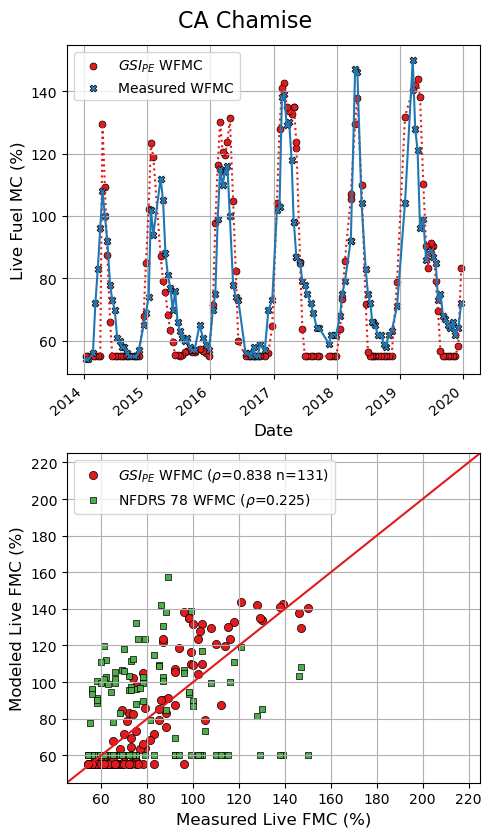

In [67]:
fout3 = "C:/Temp/CA_GSI_Chamise.jpg"
t3 = MakeFinalPlot3(Met045433,CA_Chamise,CA_ChamiseBestParams,UseLFMMinMax=True,Title="CA Chamise",UsePrcp=True,fout=fout3,Lat=Lat045433)